# Beehive in DR2

In [1]:
%run gaia-setup.ipynb

In [2]:
query = """
select *
from gaiadr2.gaia_source
where
  1=contains(point('', ra, dec),
             circle('', 130.226, 19.665, 5))
  and parallax between 4.613 and 7.312
"""
print(query)


select *
from gaiadr2.gaia_source
where
  1=contains(point('', ra, dec),
             circle('', 130.226, 19.665, 5))
  and parallax between 4.613 and 7.312



In [3]:
pmra_median, pmdec_median = -36.45, -13.15    # mas/yr

In [4]:
@cached('query_beehive.pkl')
def query_presape():
    r = gaia.query(query)
    return r
r = query_presape()
print('{:d} rows'.format(len(r)))
d = table_to_pandas(r)

using cached result from 'query_beehive.pkl'
5670 rows


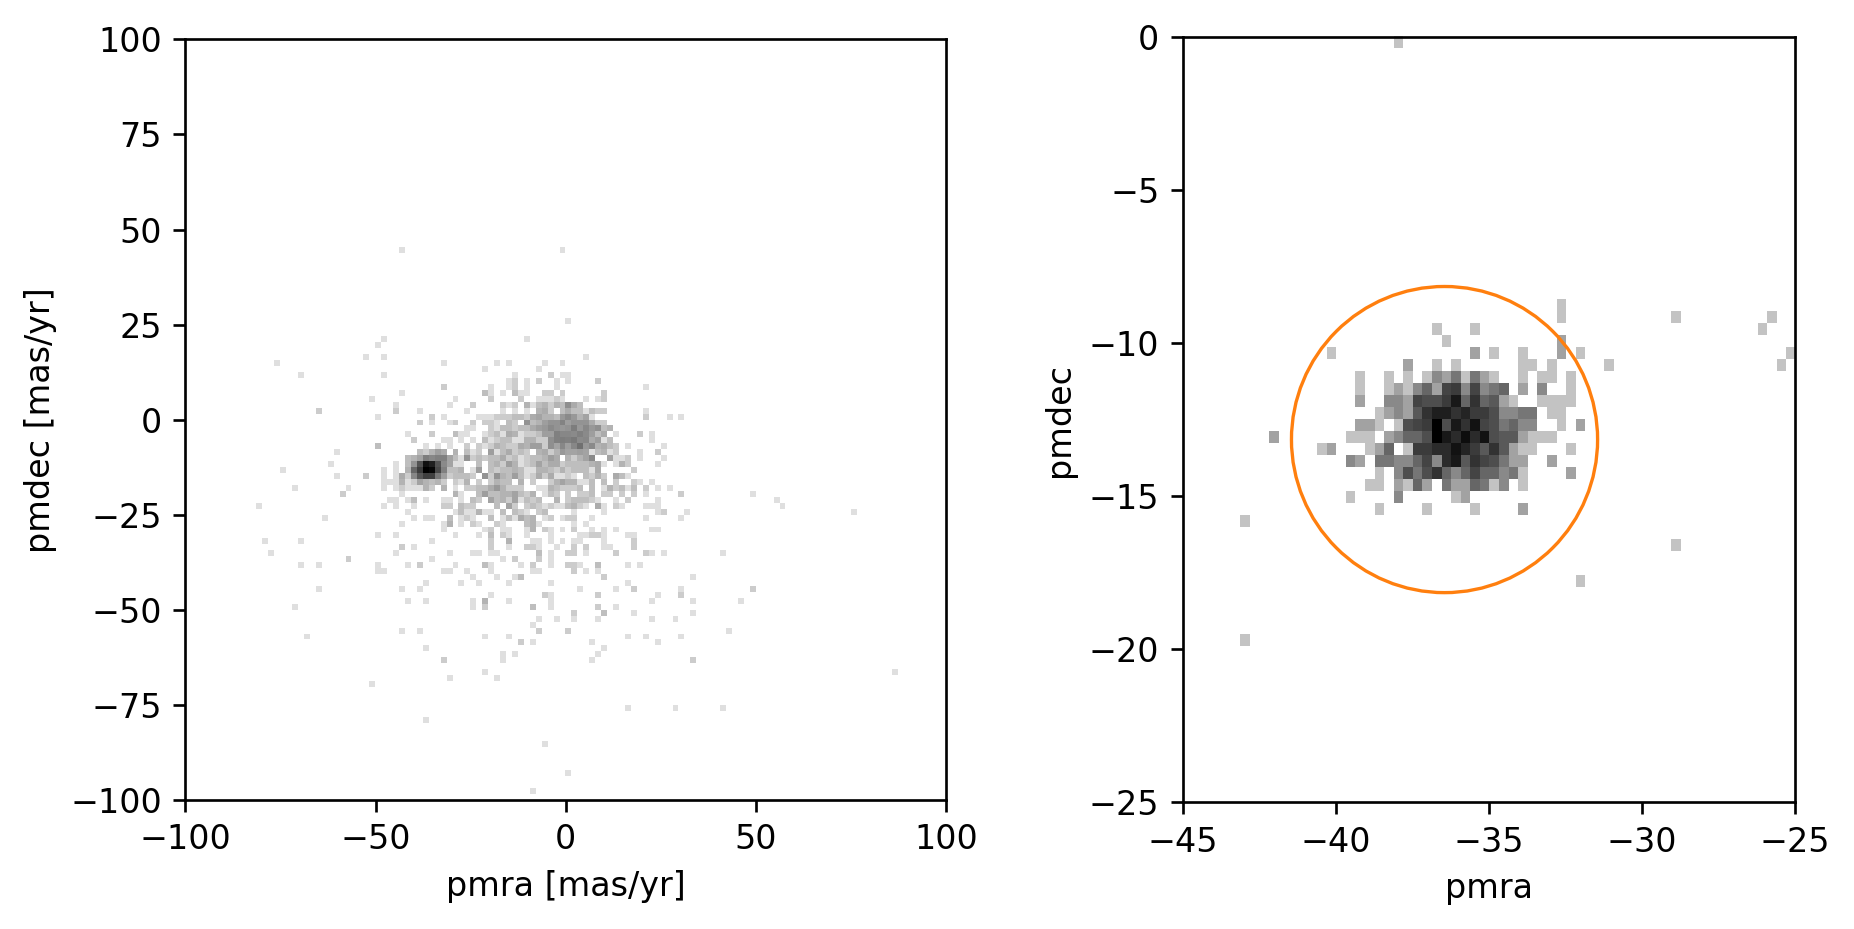

In [7]:
fig, (ax0, ax) = plt.subplots(1, 2, figsize=(8,4))

ax0.set_aspect('equal')
ax0.hist2d(d.pmra, d.pmdec, bins=128, norm=colors.LogNorm(),
           range=((-100,100),(-100,100)), cmap='gray_r')

ax.set_aspect('equal')
ax.hist2d(d.pmra, d.pmdec, bins=64, norm=colors.LogNorm(), range=((-45,-25), (-25,0)), cmap='gray_r');
ax.add_artist(patches.Circle((pmra_median, pmdec_median), radius=5,
                             facecolor='None', edgecolor='tab:orange', lw=1))
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec');
for curax in (ax0,ax0):
    curax.set_xlabel('pmra [mas/yr]')
    curax.set_ylabel('pmdec [mas/yr]')
fig.tight_layout()

In [9]:
pmmask = np.hypot(d.pmra.values - pmra_median, d.pmdec.values - pmdec_median) < 5
print('pmmask contains {:d} rows'.format(pmmask.sum()))
g = d.loc[pmmask].reset_index(drop=True)

pmmask contains 1255 rows


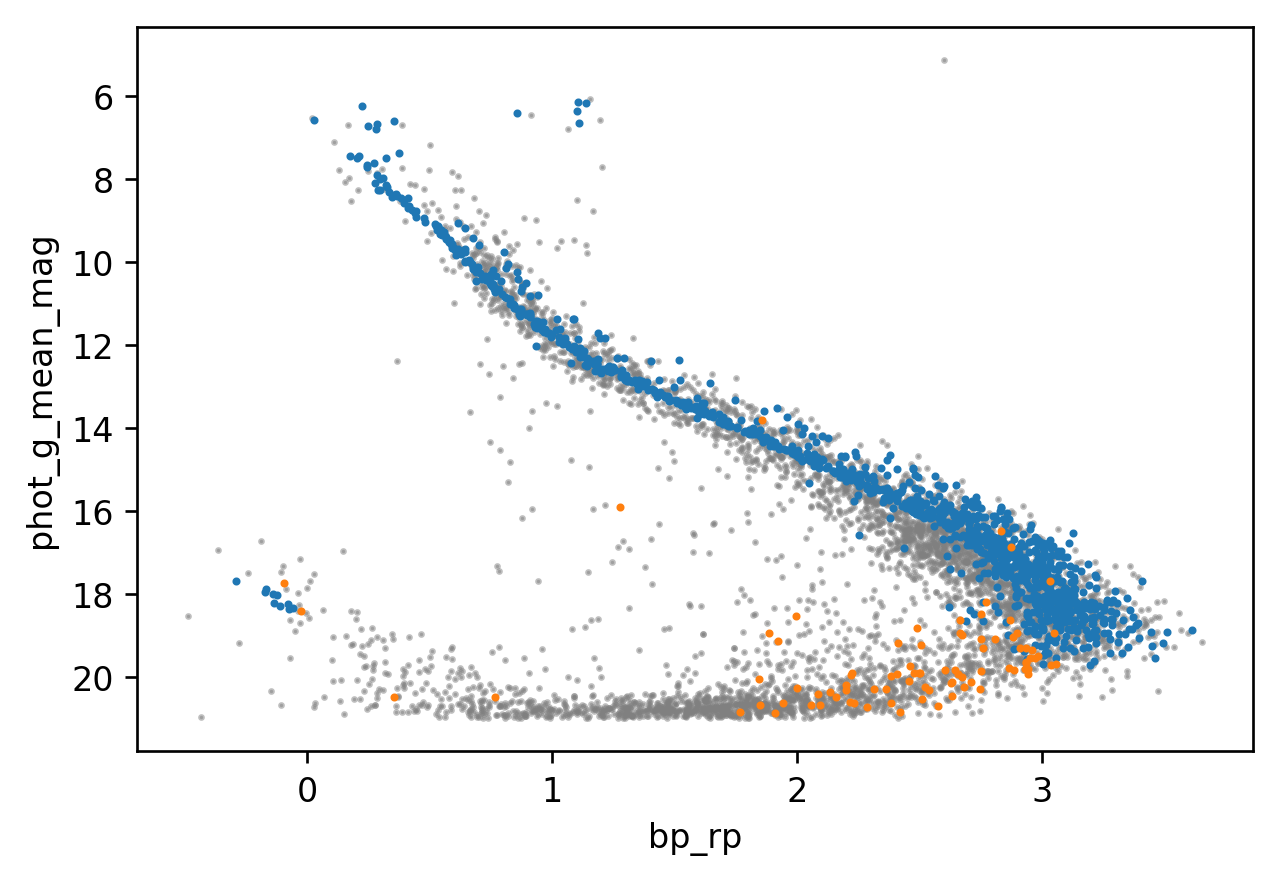

In [10]:
ax = plt.gca()
d.plot.scatter('bp_rp', 'phot_g_mean_mag', s=1, ax=ax, c='gray', alpha=.5)
g.pipe(flag_good_phot).groupby('good_phot')\
    .get_group(True).plot.scatter('bp_rp', 'phot_g_mean_mag', s=2, ax=ax);
g.pipe(flag_good_phot).groupby('good_phot')\
    .get_group(False).plot.scatter('bp_rp', 'phot_g_mean_mag', s=2, ax=ax, color='tab:orange');
plt.gca().invert_yaxis();

## Gaia-K2 cross-matches

In [11]:
# cross-match table from gaia-kepler.fun 192MB
# !wget https://www.dropbox.com/s/pf1bw7xcnk61p73/k2_dr2_1arcsec.fits

In [12]:
%%time
k2gaia = table_to_pandas(Table.read('k2_dr2_1arcsec.fits'))
print('{:d} rows'.format(len(k2gaia)))

288910 rows
CPU times: user 5.84 s, sys: 757 ms, total: 6.59 s
Wall time: 7 s


In [13]:
# Get only new k2 columns not in gaia_source
newcols = k2gaia.columns.difference(d.columns)

In [14]:
# reset index for candidate members and match by Gaia source id
match = g.reset_index(drop=True).reset_index()\
    .merge(k2gaia[list(k2gaia.columns.difference(g.columns))+['designation']], on='designation', how='left')

The cross-match table k2gaia contains duplicated (gaia source_id, epic_number) due to e.g., different k2 campaign.
Ignore duplicates.

In [15]:
match = match.drop_duplicates(subset=['designation', 'epic_number'])

In [16]:
print('{:d} / {:d} gaia sources with k2 epic match(es)'.format(
    match.drop_duplicates('designation').epic_number.notnull().sum(),
    len(match)))

1011 / 1255 gaia sources with k2 epic match(es)


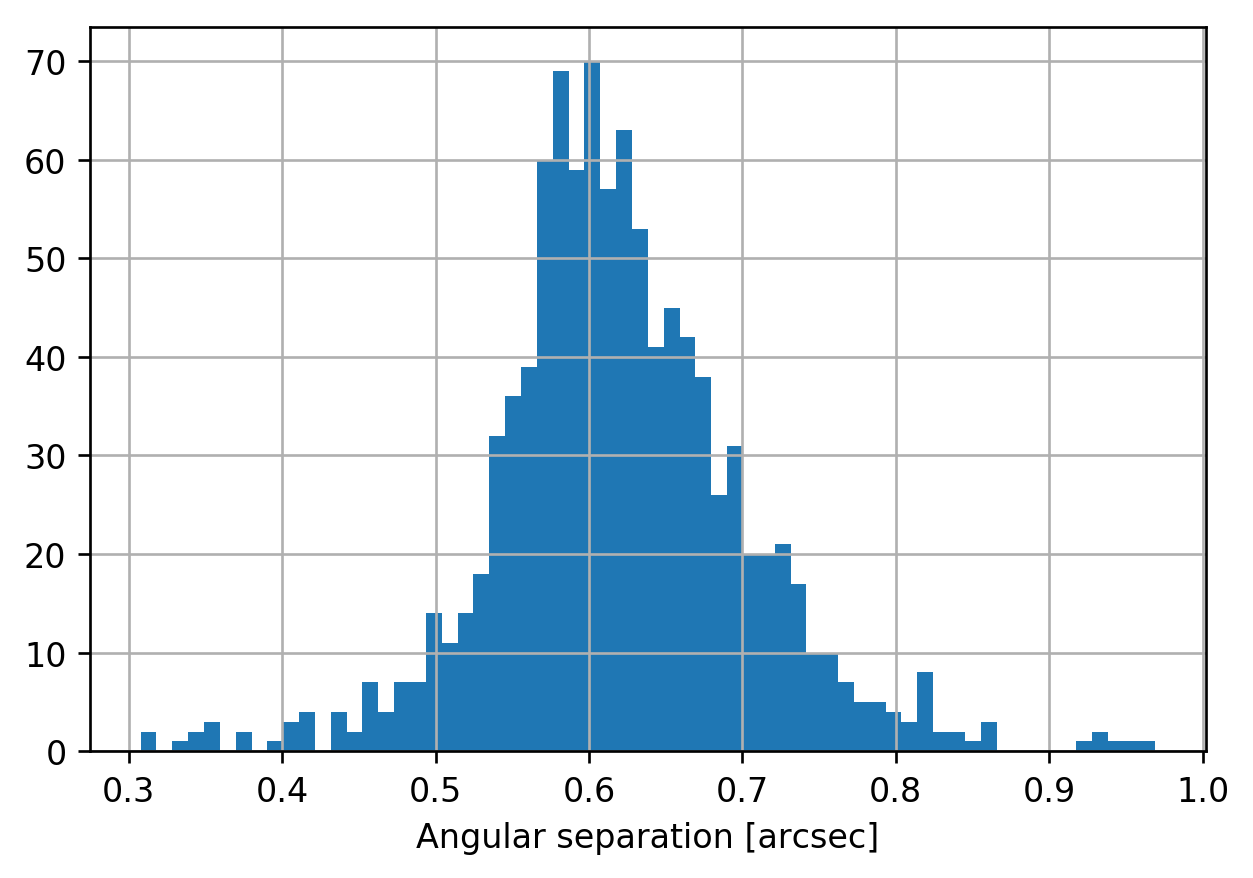

In [17]:
match.kepler_gaia_ang_dist.hist(bins=64);
plt.xlabel('Angular separation [arcsec]');

This is weird... do not really have an explanation right now.

[124, 136, 14, 28]

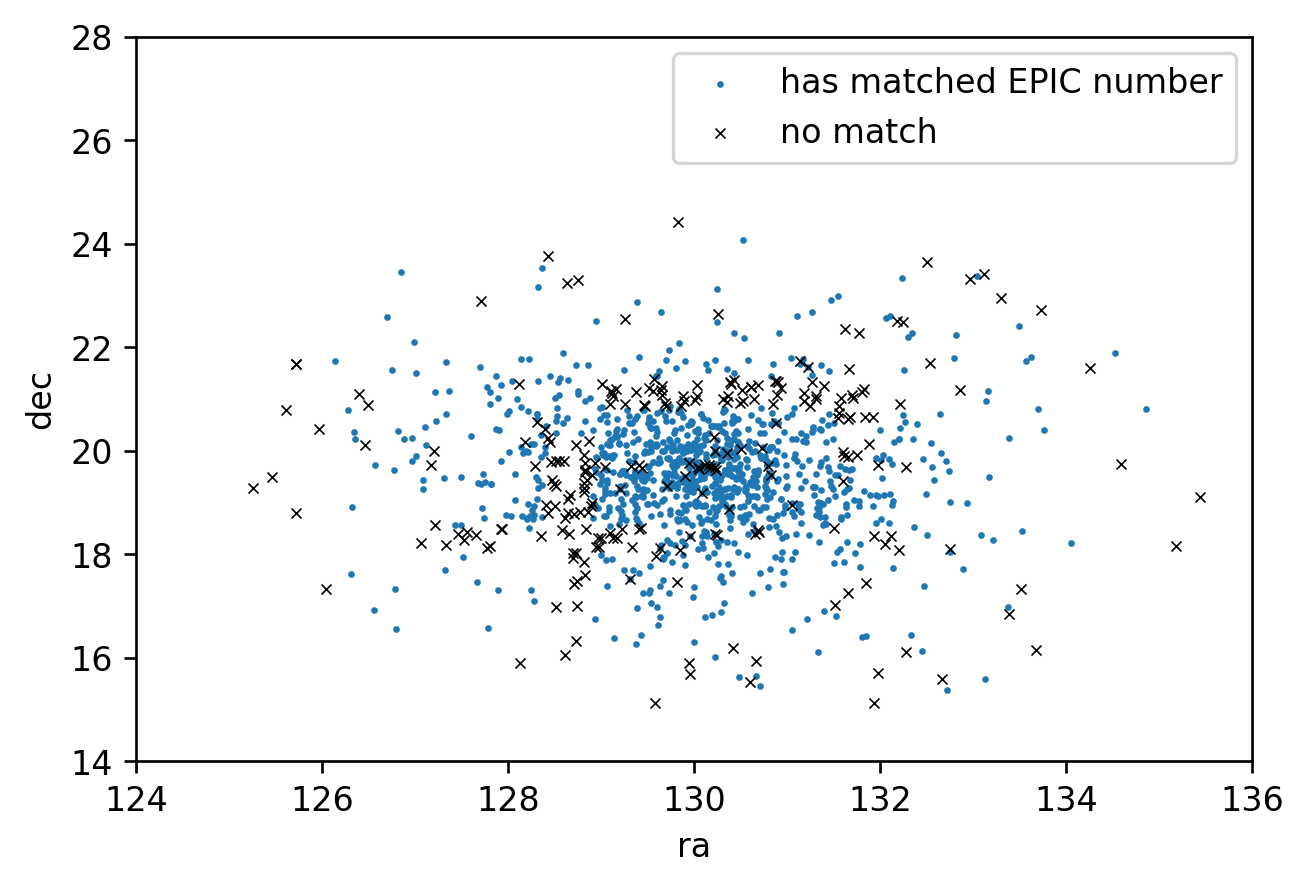

In [18]:
match.dropna(subset=['epic_number']).plot.scatter('ra', 'dec', s=1, label='has matched EPIC number');
match.loc[match.epic_number.isnull()]\
    .plot.scatter('ra', 'dec', s=9, c='k', marker='x', lw=.5,
                  label='no match', ax=plt.gca());
plt.legend();
plt.axis([124,136,14,28])

In [19]:
match[['designation'] + list(newcols)].head()

,designation,dec_kepler,epic_number,gaia_ref_epoch,k2_campaign_str,k2_lcflag,k2_logg,k2_loggerr1,k2_loggerr2,k2_mass,...,k2c_note,kepler_gaia_ang_dist,r_est,r_hi,r_length_prior,r_lo,r_modality_flag,r_result_flag,ra_kepler,tm_name
0,b'Gaia DR2 684879818643453824',20.801065,212032799.0,2015.5,b'16',1.0,NaN,NaN,NaN,NaN,...,b'N/A',0.530462,146.131220,146.994337,379.706329,145.278004,1.0,1.0,134.860402,b'2MASS J08592649+2048038'
1,b'Gaia DR2 684924555022699648',20.805542,212033074.0,2015.5,b'16',1.0,NaN,NaN,NaN,NaN,...,b'N/A',0.697859,178.940580,180.012450,383.080042,177.881177,1.0,1.0,133.700472,b'2MASS J08544811+2048201'
2,b'Gaia DR2 636437015655529472',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b'Gaia DR2 685821481633377920',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b'Gaia DR2 685854913658785024',21.879517,212092636.0,2015.5,b'5',1.0,5.08,0.04,-0.05,0.19,...,b'N/A',0.657744,202.499852,208.262870,379.695398,197.042015,1.0,1.0,134.521661,b'2MASS J08580519+2152462'


In [33]:
with open('match.pkl', 'wb') as f:
    import pickle
    pickle.dump(match, f)